In [1]:
!pip install kaggle


In [2]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download rashikrahmanpritom/plant-disease-recognition-dataset
unzip -qq "plant-disease-recognition-dataset.zip"


100%|██████████| 1.25G/1.25G [00:13<00:00, 95.8MB/s]


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import matplotlib.pyplot as plt

In [10]:
type(train)

NameError: ignored

In [9]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('valid',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
#assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

NotFoundError: ignored

In [ ]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [ ]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
resizer=tf.keras.layers.Resizing(224,224,interpolation='nearest',name='rescaler')
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                                          # make apply augmentation
train=train.map(lambda images,labels: (resizer(images),labels))
valid=valid.map(lambda images,labels: (resizer(images),labels))
test=test.map(lambda images,labels: (resizer(images),labels))

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))  # laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False                                                                            # make freeze base

In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3),batch_size=None,name='model_inputs')                                 # add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)                                         # rescale inputs
model_x=base_model(model_x)                                                                                         # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                                                            # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                                                      # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)                                  # output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_vgg16')                                         # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None) # print model summary

Model: "custom_vgg16"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 224, 224, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 224, 224, 3)                             0                 Y          
                                                                                                                                   
 vgg16 (Functional)                                   (None, 7, 7, 512)                               14714688          N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [ ]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
29/29 - 58s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 58s/epoch - 2s/step
Epoch 2/10000
29/29 - 37s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 37s/epoch - 1s/step
Epoch 3/10000
29/29 - 39s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 39s/epoch - 1s/step
Epoch 4/10000
29/29 - 38s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 38s/epoch - 1s/step
Epoch 5/10000
29/29 - 37s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 37s/epoch - 1s/step
Epoch 6/10000
29/29 - 37s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - 

In [ ]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0


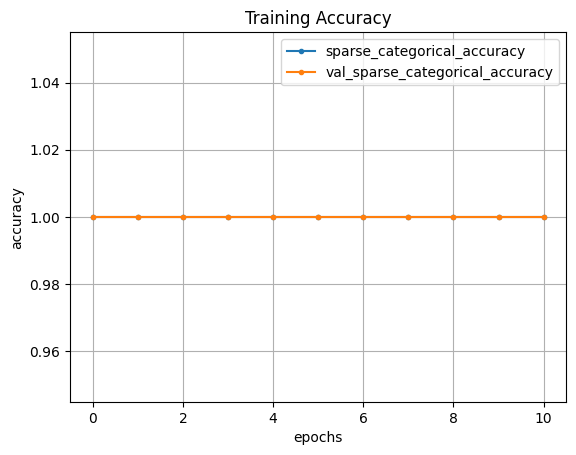

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot showv

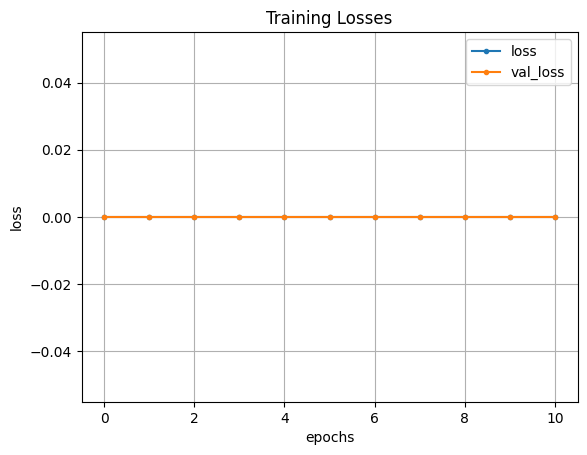

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

5/5 [==============================] - 10s 2s/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000
Testing results: {'loss': 0.0, 'sparse_categorical_accuracy': 1.0}


In [ ]:
# make save model (weights and configuration)
model.save('pro_vgg16',overwrite=True,save_format=None)               # make save

In [ ]:
!zip -r -qq "pro_vgg16.zip" "pro_vgg16"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('pro_vgg16.zip')                                       # download model zip file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp "/content/pro_vgg16.zip" "/content/drive/MyDrive/output"